In [1]:
import itertools
import numpy as np
from functools import partial
from oscar import (
    CustomExecutor,
    QiskitOptimizer,
    plot_2d_landscape,
    ScikitQuantOptimizer,
    # PDFOOptimizer,
    InterpolatedLandscapeExecutor
)
from qiskit.algorithms.optimizers import COBYLA
from math import pi
from run_landscape import evaluate_energy
import matplotlib.pyplot as plt
import pickle


def sample_energy(params, landscape, landscape_std, shots, sample_seed=42):
    energy = landscape.interpolator(params)[0]
    if shots is None:
        return energy
    energy_std = landscape_std.interpolator(params)[0] / np.sqrt(shots)
    return np.random.default_rng(sample_seed).normal(energy, energy_std)

def calculate_ar(po_problem, energy):
    min_constrained = po_problem["feasible_min"]
    max_constrained = po_problem["feasible_max"]
    return (energy - max_constrained) / (min_constrained - max_constrained)

In [2]:
# depth_pool = [1]
# qubit_pool = [14]
# seed_pool = [0]
# maxfev_pool = range(4, 8)
# resolutions = [64, 64]
# bounds = [(-1.4, -0.8), (0.9, 1.3)]
# # resolutions = [64, 64]
# # bounds = [(-pi / 4, pi / 4), (-pi / 2, pi / 2)]
# sample_seed = 42
# method = "uobyqa"
# method_pool = ["uobyqa", "newuoa", "bobyqa", "lincoa", "cobyla", "imfil", "snobfit"]
# budget = 10000
# initial_point = [-1.24727193, 1.04931211]
# fontsize = 12

# for p, n, seed, maxfev in itertools.product(depth_pool, qubit_pool, seed_pool, maxfev_pool):
#     shots = None if maxfev is None else budget // maxfev
#     print(f"{p=} {n=} {seed=} {maxfev=} {shots=}")
#     filename = f"data/landscapes/{p=}/{n=}/{p=}-{n=}-{seed=}-{bounds}-{resolutions}"
#     landscape = np.load(filename + ".pckl", allow_pickle=True)
#     print("Grid minima: ", landscape.optimal_params().flatten(), landscape.optimal_value())
#     landscape_std = np.load(filename + "-std.pckl", allow_pickle=True)
#     itpl_executor = CustomExecutor(
#         partial(
#             sample_energy,
#             landscape=landscape,
#             landscape_std=landscape_std,
#             shots=shots,
#             sample_seed=sample_seed,
#         )
#     )
#     for itpl_executor in [
#             itpl_executor, 
#             # CustomExecutor(partial(evaluate_energy, p=p, n=n, problem_seed=seed, shots=shots, sample_seed=sample_seed))
#         ]:
#         if method in ["imfil", "snobfit"]:
#             trace, _ = ScikitQuantOptimizer(method, maxfev).run(
#                 itpl_executor, initial_point=initial_point, bounds=bounds
#             )
#         elif method in ["uobyqa", "newuoa"]:
#             trace, _ = PDFOOptimizer(method, maxfev).run(
#                 itpl_executor, initial_point=initial_point, rhobeg=0.1
#             )
#         else:
#             trace, _ = PDFOOptimizer(method, maxfev).run(
#                 itpl_executor, initial_point=initial_point, bounds=bounds, rhobeg=0.1
#             )
#         print(f"Total time: {sum(trace.time_trace)}")
#         print("Optimal parameters reported: ", trace.optimal_params)
#         print("Corresponding optimal value: ", itpl_executor.run(trace.optimal_params))
#         print("Number of evaluations: ", trace.num_fun_evals)
#         figure = plot_2d_landscape(landscape, trace, "auto", show=False)
#         # figure.axes[1].tick_params(labelsize=fontsize)
#         # plt.xticks(fontsize=fontsize)
#         # plt.yticks(fontsize=fontsize)
#         plt.legend(fontsize=fontsize)
#         # plt.xlim(-1, 0)
#         # plt.ylim(0.7, 1.3)
#         plt.show()

In [33]:
depth_pool = [1]
qubit_pool = [14, 16, 18]
seed_pool = list(range(10))
resolutions = [128, 32]
bounds = [(-2.2, -0.6), (0.9, 1.3)]
# shot_pool = range(100, 1601, 500)
# maxfev_pool = list(range(5, 100))
maxfev_pool = list(range(7, 21)) + [25, 33, 50, 66, 100]
initial_point = [-1.24727193, 1.04931211]
# initial_point = [-2.2, 1.]
sample_seed_pool = list(range(10))
# method_pool = ["uobyqa", "newuoa", "bobyqa", "lincoa", "cobyla"]  # , "imfil", "snobfit"]
method_pool = ["RECOBYLA", "COBYLA"]
# method_pool = ["COBYLA", "POWELL", "L_BFGS_B", "SLSQP", "SPSA", "NELDER_MEAD", "BOBYQA", "IMFIL"]
budget = 10000
rhobeg_pool = [0.25]
# rhobeg_pool = np.linspace(0.002, 0.01, 5).tolist() + np.linspace(0.02, 0.1, 5).tolist()
# rhobeg_pool = np.linspace(0.001, 0.01, 10).tolist() + np.linspace(0.02, 0.1, 9).tolist()
xtol_abs = 0.06
scaling = 2

configs = []
for method, maxfev, rhobeg in itertools.product(method_pool, maxfev_pool, rhobeg_pool):
    shots = budget // maxfev
    if method in ["snobfit", "imfil"] and rhobeg != rhobeg_pool[0]:
        continue
    # elif method == "":
    configs.append((method, maxfev, shots, rhobeg))
mean_ar = np.zeros(len(configs), dtype=float)
solved_ratio = np.zeros(len(configs), dtype=float)
num_instances = len(depth_pool) * len(qubit_pool) * len(seed_pool)
print(f"Trying {len(configs)} configs on {num_instances} instances...")

grid_best_ar, initial_point_ar = [], []
for p, n, seed in itertools.product(depth_pool, qubit_pool, seed_pool):
    print(f"Landscape {p=} {n=} {seed=}")
    filename = f"data/landscapes/{p=}/{n=}/{p=}-{n=}-{seed=}-{bounds}-{resolutions}"
    landscape = np.load(filename + ".pckl", allow_pickle=True)
    print("Grid minima: ", landscape.optimal_params().flatten(), landscape.optimal_value())
    landscape_std = np.load(filename + "-std.pckl", allow_pickle=True)
    po_problem = pickle.load(
        open(f"data/random/po_problem_rule_{n}_{n//2}_0.5_seed{seed}.pckl", "rb")
    )
    true_executor = InterpolatedLandscapeExecutor(landscape)
    grid_best_ar.append(calculate_ar(po_problem, landscape.optimal_value()))
    initial_point_ar.append(calculate_ar(po_problem, true_executor.run(initial_point)))

    energies, solved_counts = [], []
    for method, maxfev, shots, rhobeg in configs:
        energy = 0
        for sample_seed in range(sample_seed_pool):
            itpl_executor = CustomExecutor(
                partial(
                    sample_energy,
                    landscape=landscape,
                    landscape_std=landscape_std,
                    shots=shots,
                    sample_seed=sample_seed,
                )
            )
            if method == "RECOBYLA":
                from restarting_cobyla import RECOBYLA

                trace, result = RECOBYLA().run(
                    CustomExecutor(
                        partial(
                            sample_energy,
                            landscape=landscape,
                            landscape_std=landscape_std,
                            sample_seed=sample_seed,
                        )
                    ), initial_point, budget, bounds, rhobeg, xtol_abs, shots, scaling, p
                )
            # elif method in ["uobyqa", "newuoa"]:
            #     trace, _ = PDFOOptimizer(method, maxfev).run(
            #         itpl_executor, initial_point=initial_point, rhobeg=rhobeg
            #     )
            # elif method in ["bobyqa", "lincoa", "cobyla"]:
            #     trace, _ = PDFOOptimizer(method, maxfev).run(
            #         itpl_executor, initial_point=initial_point, bounds=bounds, rhobeg=rhobeg
            #     )
            else:
                from qiskit.algorithms import optimizers as qiskit_optimizers

                trace, _ = QiskitOptimizer(
                    getattr(qiskit_optimizers, method)(
                        maxiter=maxfev, rhobeg=rhobeg
                    )
                ).run(itpl_executor, initial_point=initial_point, bounds=bounds)
            # if trace.num_fun_evals > maxfev:
            # plot_2d_landscape(landscape, trace, figure=plt.figure(figsize=(12, 3)))
            energy += true_executor.run(trace.optimal_params)
        print(method, maxfev, shots, trace.num_fun_evals, trace.num_iters, result["used_budget"])
        energies.append(energy / len(sample_seed_pool))
    ar = calculate_ar(po_problem, np.array(energies))
    mean_ar = mean_ar + ar
    solved_counts = (grid_best_ar[-1] - ar) <= grid_best_ar[-1] * 0.01
    solved_ratio += np.array(solved_counts, dtype=float)

mean_ar /= num_instances
solved_ratio /= num_instances

Trying 38 configs on 30 instances...
Landscape p=1 n=14 seed=0
Grid minima:  [-1.1375  1.05  ] 0.07404427012749953
RECOBYLA 7 1428 7 1 9996
RECOBYLA 8 1250 7 1 8750
RECOBYLA 9 1111 7 1 7777
RECOBYLA 10 1000 10 1 10000
RECOBYLA 11 909 9 1 8181
RECOBYLA 12 833 11 1 9163
RECOBYLA 13 769 7 1 5383
RECOBYLA 14 714 13 1 9282
RECOBYLA 15 666 11 2 9990
RECOBYLA 16 625 12 1 7500
RECOBYLA 17 588 13 2 9996
RECOBYLA 18 555 12 1 6660
RECOBYLA 19 526 13 2 9468
RECOBYLA 20 500 13 2 9500
RECOBYLA 25 400 19 2 9600
RECOBYLA 33 303 15 2 6666
RECOBYLA 50 200 22 3 9800
RECOBYLA 66 151 31 3 9664
RECOBYLA 100 100 29 4 9300
COBYLA 7 1428 7 None 9300
COBYLA 8 1250 8 None 9300
COBYLA 9 1111 9 None 9300
COBYLA 10 1000 10 None 9300
COBYLA 11 909 11 None 9300
COBYLA 12 833 12 None 9300
COBYLA 13 769 13 None 9300
COBYLA 14 714 14 None 9300
COBYLA 15 666 15 None 9300
COBYLA 16 625 16 None 9300
COBYLA 17 588 17 None 9300
COBYLA 18 555 18 None 9300
COBYLA 19 526 19 None 9300
COBYLA 20 500 20 None 9300
COBYLA 25 400 25 

In [34]:
print("Grid best AR: ", np.mean(grid_best_ar))
print("Initial point AR: ", np.mean(initial_point_ar))
for i in np.argsort(mean_ar)[-1:-100:-1]:
    print(mean_ar[i], configs[i])
print()
for i in np.argsort(solved_ratio)[-1:-100:-1]:
    print(solved_ratio[i], configs[i])

Grid best AR:  0.7391871281890803
Initial point AR:  0.7193904049067792
0.7358302592659446 ('COBYLA', 7, 1428, 0.25)
0.7356212850764264 ('COBYLA', 8, 1250, 0.25)
0.7353828691967739 ('COBYLA', 10, 1000, 0.25)
0.7353736855412522 ('COBYLA', 11, 909, 0.25)
0.7353559735963524 ('RECOBYLA', 7, 1428, 0.25)
0.7351178358531307 ('COBYLA', 9, 1111, 0.25)
0.7350852704556146 ('COBYLA', 14, 714, 0.25)
0.7350227659605487 ('RECOBYLA', 8, 1250, 0.25)
0.734850023277279 ('COBYLA', 13, 769, 0.25)
0.7347736103703091 ('COBYLA', 12, 833, 0.25)
0.7343489935778287 ('COBYLA', 15, 666, 0.25)
0.7343026043395279 ('RECOBYLA', 11, 909, 0.25)
0.734252338825222 ('COBYLA', 16, 625, 0.25)
0.7341955123741359 ('RECOBYLA', 25, 400, 0.25)
0.7341858468721869 ('COBYLA', 20, 500, 0.25)
0.734151872371374 ('RECOBYLA', 9, 1111, 0.25)
0.7340533768208954 ('RECOBYLA', 18, 555, 0.25)
0.7340467745132055 ('COBYLA', 17, 588, 0.25)
0.7339778955128795 ('RECOBYLA', 10, 1000, 0.25)
0.7338913582767919 ('RECOBYLA', 17, 588, 0.25)
0.73373541579

ValueError: x and y must have same first dimension, but have shapes (19,) and (38,)

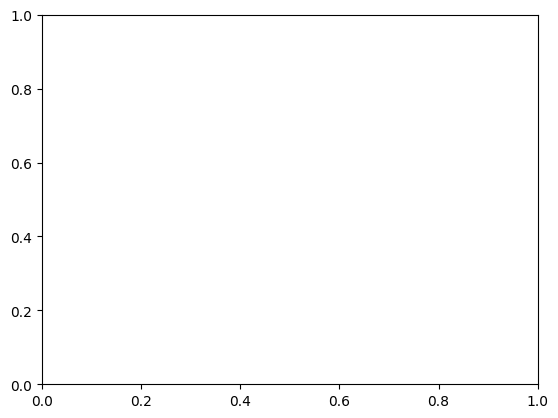

In [25]:
plt.figure()
plt.plot(maxfev_pool, mean_ar, label=f"{method}")
plt.xlabel("Max function evaluations")
plt.ylabel("Mean approximation ratio")
# plt.ylim(0.71, 0.74)
plt.axhline(np.mean(grid_best_ar), label="Grid best AR", color='r')
plt.axhline(np.mean(initial_point_ar), label="Initial point AR", color='g')
plt.legend()

Total time: 0.008681535720825195
Optimal parameters reported:  [-1.24736413  1.29935082]
Optimal value reported:  -0.040451584829139034
Number of evaluations:  23


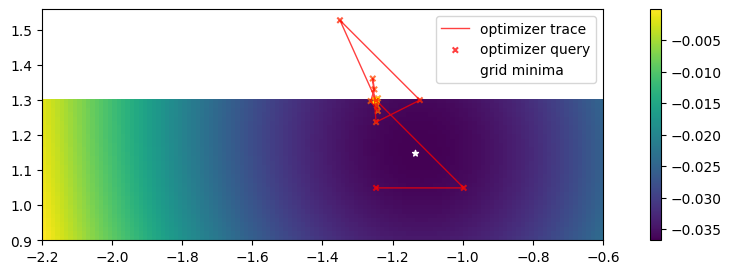

In [35]:
from oscar import plot_2d_landscape

# plot_2d_landscape(landscape_std, trace, figure=plt.figure(figsize=(12, 3)))
plot_2d_landscape(landscape, trace, figure=plt.figure(figsize=(12, 3)), show=False)
# plt.xlim(-1.4, -1)
trace.print_result()

In [7]:
pickle.dump(
    {
        "mean_ar": mean_ar,
        "solved_ratio": solved_ratio,
        "configs": configs,
        "method_pool": method_pool,
        "maxfev_pool": maxfev_pool,
        "rhobeg_pool": rhobeg_pool,
        "depth_pool": depth_pool,
        "qubit_pool": qubit_pool,
        "seed_pool": seed_pool,
        "resolutions": resolutions,
        "bounds": bounds,
        "initial_point": initial_point,
        "sample_seed": sample_seed,
        "budget": budget,
    },
    open(
        f"data/configs/m{len(method_pool)}-f{len(maxfev_pool)}-r{len(rhobeg_pool)}-d{len(depth_pool)}-q{len(qubit_pool)}-s{len(seed_pool)}",
        "wb",
    ),
)

In [8]:
depth_pool = [1]
qubit_pool = [14, 16, 18]
seed_pool = list(range(10))
resolutions = [128, 32]
bounds = [(-2.2, -0.6), (0.9, 1.3)]
initial_point = [-1.24727193, 1.04931211]
shots_pool = range(100, 1601, 500)
maxfev_pool = list(range(5, 100))
sample_seed = None
method_pool = ["RECOBYLA"]
budget = 100000
rhobeg_pool = [0.1]
# rhobeg_pool = np.linspace(0.001, 0.01, 10).tolist() + np.linspace(0.02, 0.1, 9).tolist()
xtol_abs = 0.01
scaling = 2

configs = []
for method, maxfev, rhobeg in itertools.product(method_pool, maxfev_pool, rhobeg_pool):
    shots = budget // maxfev
    if method in ["snobfit", "imfil"] and rhobeg != rhobeg_pool[0]:
        continue
    # elif method == "":
    configs.append((method, maxfev, shots, rhobeg))
mean_ar = np.zeros(len(configs), dtype=float)
solved_ratio = np.zeros(len(configs), dtype=float)
num_instances = len(depth_pool) * len(qubit_pool) * len(seed_pool)
print(f"Trying {len(configs)} configs on {num_instances} instances...")

grid_best_ar, initial_point_ar = [], []
for p, n, seed in itertools.product(depth_pool, qubit_pool, seed_pool):
    print(f"Landscape {p=} {n=} {seed=}")
    filename = f"data/landscapes/{p=}/{n=}/{p=}-{n=}-{seed=}-{bounds}-{resolutions}"
    landscape = np.load(filename + ".pckl", allow_pickle=True)
    print("Grid minima: ", landscape.optimal_params().flatten(), landscape.optimal_value())
    landscape_std = np.load(filename + "-std.pckl", allow_pickle=True)
    po_problem = pickle.load(
        open(f"data/random/po_problem_rule_{n}_{n//2}_0.5_seed{seed}.pckl", "rb")
    )
    true_executor = InterpolatedLandscapeExecutor(landscape)
    grid_best_ar.append(calculate_ar(po_problem, landscape.optimal_value()))
    initial_point_ar.append(calculate_ar(po_problem, true_executor.run(initial_point)))

    energies, solved_counts = [], []
    for method, maxfev, shots, rhobeg in configs:
        itpl_executor = CustomExecutor(
            partial(
                sample_energy,
                landscape=landscape,
                landscape_std=landscape_std,
                shots=shots,
                sample_seed=sample_seed,
            )
        )
        if method == "RECOBYLA":
            from restarting_cobyla import RECOBYLA

            trace, _ = RECOBYLA().run(
                CustomExecutor(
                    partial(
                        sample_energy,
                        landscape=landscape,
                        landscape_std=landscape_std,
                        sample_seed=sample_seed,
                    )
                ), initial_point, budget, bounds, rhobeg, xtol_abs, shots, scaling, p
            )
        # elif method in ["uobyqa", "newuoa"]:
        #     trace, _ = PDFOOptimizer(method, maxfev).run(
        #         itpl_executor, initial_point=initial_point, rhobeg=rhobeg
        #     )
        # elif method in ["bobyqa", "lincoa", "cobyla"]:
        #     trace, _ = PDFOOptimizer(method, maxfev).run(
        #         itpl_executor, initial_point=initial_point, bounds=bounds, rhobeg=rhobeg
        #     )
        else:
            from qiskit.algorithms import optimizers as qiskit_optimizers

            trace, _ = QiskitOptimizer(
                getattr(qiskit_optimizers, method)(
                    maxiter=maxfev, options={"rhobeg": rhobeg}
                )
            ).run(itpl_executor, initial_point=initial_point, bounds=bounds)
        if trace.num_fun_evals > maxfev:
            print(method, maxfev, shots, trace.num_fun_evals)
        # plot_2d_landscape(landscape, trace, figure=plt.figure(figsize=(12, 12)))
        energies.append(true_executor.run(trace.optimal_params))
        # solved_counts.append(
        #     int(np.allclose(trace.optimal_params, landscape.optimal_params(), 0, 0.1))
        # )
    ar = calculate_ar(po_problem, np.array(energies))
    mean_ar = mean_ar + ar
    solved_counts = (grid_best_ar[-1] - ar) <= grid_best_ar[-1] * 0.01
    solved_ratio += np.array(solved_counts, dtype=float)

mean_ar /= num_instances
solved_ratio /= num_instances

Trying 95 configs on 30 instances...
Landscape p=1 n=14 seed=0
Grid minima:  [-1.1375  1.05  ] 0.07404427012749953
RECOBYLA 5 20000 15
RECOBYLA 6 16666 11
RECOBYLA 7 14285 13
RECOBYLA 8 12500 10
RECOBYLA 9 11111 12
RECOBYLA 10 10000 11
RECOBYLA 12 8333 14
RECOBYLA 22 4545 23
RECOBYLA 23 4347 28
Landscape p=1 n=14 seed=1
Grid minima:  [-1.575  1.   ] 0.01805364419413583
RECOBYLA 5 20000 19
RECOBYLA 6 16666 18
RECOBYLA 7 14285 14
RECOBYLA 8 12500 18
RECOBYLA 9 11111 12
RECOBYLA 10 10000 16
RECOBYLA 11 9090 16
RECOBYLA 12 8333 13
RECOBYLA 13 7692 16
RECOBYLA 14 7142 15
RECOBYLA 16 6250 18
RECOBYLA 21 4761 31
RECOBYLA 22 4545 27
RECOBYLA 23 4347 24
RECOBYLA 24 4166 29
RECOBYLA 25 4000 27
RECOBYLA 26 3846 27
RECOBYLA 27 3703 30
RECOBYLA 31 3225 35


KeyboardInterrupt: 

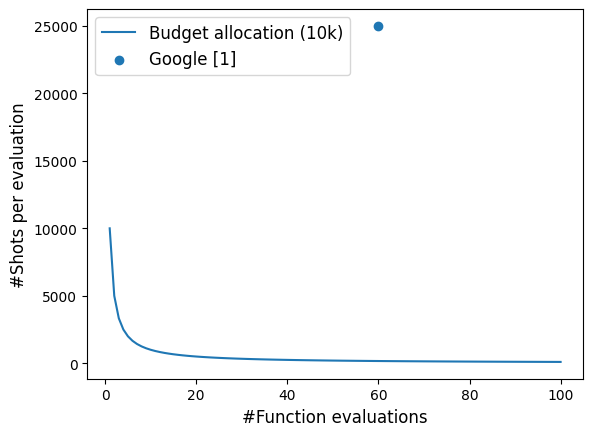

In [ ]:
plt.figure()
fontsize = 12
x = np.linspace(1, 100, 100)
plt.plot(x, 10000 / x, label="Budget allocation (10k)")
plt.xlabel("#Function evaluations", fontsize=fontsize)
plt.ylabel("#Shots per evaluation", fontsize=fontsize)
plt.scatter(60, 25000, label="Google [1]")
plt.legend(fontsize=fontsize)

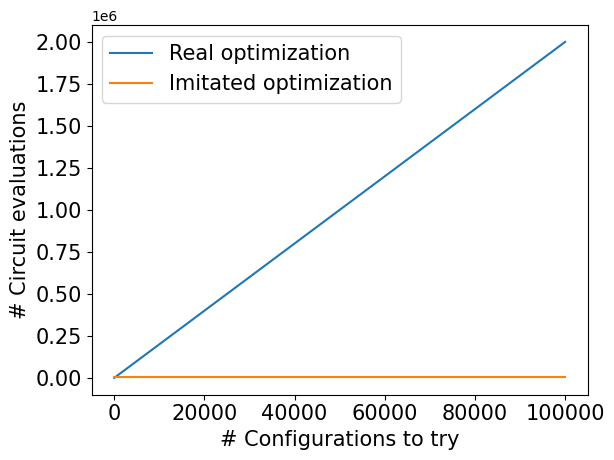

In [ ]:
x = np.linspace(0, 100000, 100)
fontsize = 15
plt.figure()
plt.plot(x, 20 * x, label="Real optimization")
plt.plot(x, np.array([2**12] * len(x)), label="Imitated optimization")
plt.xlabel("# Configurations to try", fontsize=fontsize)
plt.ylabel("# Circuit evaluations", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)